# Airbnb Data Mining Notebook

In this notebook we are going to deal with data from a well-known residential rental application, Airbnb. Specifically, based on the data for the Athens area for 3 months of 2019 (February, March and April), we are going to answer the following question: 
- What is the most common type of room_type for our data?
- Plot graphs showing the fluctuation of prices for the 3 month period.
- What are the top 5 neighborhoods with the most reviews?
- What is the neighborhood with most real estate listings?
- How many entries are per neighborhood and per month?
- Plot the histogram of the neighborhood_group variable.
- What is the most common type of room (room_type)?
- What is the most common room type (room_type) in each neighborhood (neighborhood_group)?
- What is the most expensive room type?

## Import Libraries

In [1]:
# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")  
# Specialized container datatypes
import collections
# For Map vizualization
import folium
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Natural language processing library
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.collocations import (
    BigramAssocMeasures,
    BigramCollocationFinder)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
# For random selection 
import random
# For basic cleaning and data preprocessing 
import re
import string 
# Communicating with operating and file system
import os
# Machine learning libary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# For wordcloud generating 
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pantelis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pantelis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Dataset

Read the data using pandas' read_csv method and let's look at the dataset info to see if everything is alright.

In [2]:
DATASET = "./data/train.csv"
df = pd.read_csv(DATASET)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28122 entries, 0 to 28121
Data columns (total 31 columns):
id                        28122 non-null int64
month                     28122 non-null object
name                      28092 non-null object
description               27833 non-null object
transit                   19212 non-null object
host_since                28120 non-null object
host_response_rate        23067 non-null object
host_has_profile_pic      28120 non-null object
host_identity_verified    28120 non-null object
neighbourhood             27861 non-null object
city                      28113 non-null object
zipcode                   27204 non-null object
latitude                  28122 non-null float64
longitude                 28122 non-null float64
property_type             28122 non-null object
room_type                 28122 non-null object
accommodates              28122 non-null int64
bathrooms                 28122 non-null float64
bedrooms                  

In [3]:
df.head()

,id,month,name,description,transit,host_since,host_response_rate,host_has_profile_pic,host_identity_verified,neighbourhood,...,amenities,price,minimum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,instant_bookable,cancellation_policy
0,10595,February,"96m2, 3BR, 2BA, Metro, WI-FI etc...",Athens Furnished Apartment No6 is 3-bedroom ap...,Note: 5-day ticket for all the public transpor...,2009-09-08,100%,t,t,Ambelokipi,...,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$71.00,1,294,17,2011-05-20,2019-01-12,96.0,t,strict_14_with_grace_period
1,10988,February,"75m2, 2-br, metro, wi-fi, cable TV",Athens Furnished Apartment No4 is 2-bedroom ap...,Note: 5-day ticket for all the public transpor...,2009-09-08,100%,t,t,Ambelokipi,...,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$82.00,1,0,31,2012-10-21,2017-11-23,92.0,t,strict_14_with_grace_period
2,10990,February,"50m2, Metro, WI-FI, cableTV, more",Athens Furnished Apartment No3 is 1-bedroom ap...,Note: 5-day ticket for all the public transpor...,2009-09-08,100%,t,t,Ambelokipi,...,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$47.00,1,282,27,2012-09-06,2019-02-01,97.0,t,strict_14_with_grace_period
3,10993,February,"Studio, metro, cable tv, wi-fi, etc",The Studio is an -excellent located -close t...,Note: 5-day ticket for all the public transpor...,2009-09-08,100%,t,t,Ambelokipi,...,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$37.00,1,286,42,2012-09-24,2019-02-02,97.0,t,strict_14_with_grace_period
4,10995,February,"47m2, close to metro,cable TV,wi-fi",AQA No2 is 1-bedroom apartment (47m2) -excell...,Note: 5-day ticket for all the public transpor...,2009-09-08,100%,t,t,Ambelokipi,...,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$47.00,2,308,16,2010-07-08,2019-01-11,95.0,t,strict_14_with_grace_period


For the time being, null values won't be discared. That's why in case we deleted all the null objects, we would exclude a sizeable portion of the data set, and maybe without any meaningful reason. So, we are going to tackle each question step by step and only in case of need we will discard null objects.

## Question 1.1

What is the most common type of room_type for our data?

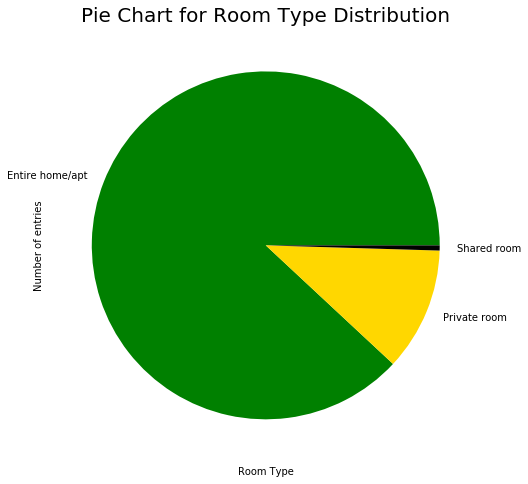

In [4]:
df['room_type'].value_counts().plot(kind = 'pie', colors=['green', 'gold', 'black'], figsize = (8, 8))
plt.title('Pie Chart for Room Type Distribution', fontsize = 20)
plt.xlabel('Room Type')
plt.ylabel('Number of entries')
plt.show()

It is crystal clear that the most common type of rooms is 'Entire home/apartment'

In [5]:
print('Number of entries for "Entire home/apartment": {}'.format(max(df['room_type'].value_counts())))

Number of entries for "Entire home/apartment": 24765


## Question 1.2

Plot graphs showing the fluctuation of prices for the 3 month period.

In [6]:
# In order to plot numerical data we have to clean 'price' column by remove '$' symbol in each row
def remove_dollar(row):
    if row[0] == '$':
        return row[1:]
    return row

df['price'] = df['price'].apply(lambda row: float(remove_dollar(row).replace(',','')))

In [7]:
# Calculate mean price for each month
mean_prices = []
months = ['February', 'March', 'April']
for month in months:
    mean_prices.append(np.mean(df.loc[df['month'] == month]['price']))

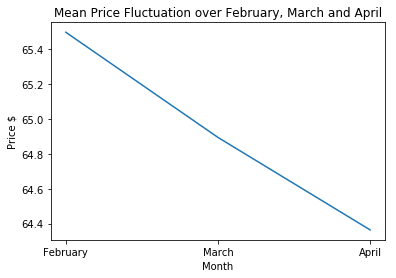

In [8]:
# Plot price fluctuation over the 3 months
plot = plt.plot(months, mean_prices)
plt.xlabel('Month')
plt.ylabel('Price $')
plt.title('Mean Price Fluctuation over February, March and April')
plt.show()

In [9]:
for i, month in enumerate(months):
    print("Mean price in month {}: ${:.2f}".format(month, mean_prices[i]))

Mean price in month February: $65.50
Mean price in month March: $64.89
Mean price in month April: $64.36


## Question 1.3

 What are the top 5 neighborhoods with the most reviews?

Text(0.5, 1.0, 'Distribution of reviews in the top neighbourhoods')

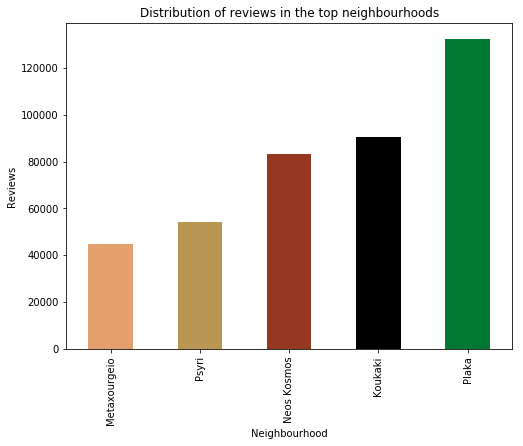

In [10]:
neighs = df.groupby('neighbourhood')
reviews = neighs['number_of_reviews'].sum().sort_values().tail(5)

reviews.plot(kind = 'bar', color=['#e59e6d', '#ba9653', '#963821', 'black', '#007a33'], figsize = (8, 6))
plt.xlabel('Neighbourhood')
plt.ylabel('Reviews')
plt.title('Distribution of reviews in the top neighbourhoods')

In [11]:
# Get the previously found neighbourhoods as a list
list_of_neighs = reviews.keys().tolist()
n_reviews = reviews.tolist()
# And print its members
print("Top 5 neighbourhoods are: \n")
for i,n in enumerate(list_of_neighs):
    print('{} with {} reviews'.format(n, n_reviews[i]))

Top 5 neighbourhoods are: 

Metaxourgeio with 44792 reviews
Psyri with 54353 reviews
Neos Kosmos with 83348 reviews
Koukaki with 90357 reviews
Plaka with 132361 reviews


## Question 1.4

What is the neighborhood with most real estate listings?


In [12]:
res = df['neighbourhood'].value_counts()
# We want the most common neighbourhood, thus the head of the list
neig = res.keys().tolist()[0]
# And also the properties it has
n_props = res.tolist()[0]
print("The neighbourhood with the most listings is {} with {} properties".format(neig, n_props))

The neighbourhood with the most listings is Plaka with 3143 properties


## Question 1.5


How many entries are per neighborhood and per month?


### Entries per month

In [13]:
neighbourhoods = df['neighbourhood'].value_counts().keys().tolist()
months = df['month'].value_counts().keys().tolist()

for neighbourhood in neighbourhoods:
    for month in reversed(months):
        print("{} in {}: {}".format(neighbourhood, month, 
            df.loc[(df['neighbourhood'] == neighbourhood) & (df['month'] == month)]['month'].value_counts().tolist()[0]))
    print("----------------------------")

Plaka in February: 990
Plaka in March: 1037
Plaka in April: 1116
----------------------------
Neos Kosmos in February: 777
Neos Kosmos in March: 791
Neos Kosmos in April: 809
----------------------------
Koukaki in February: 741
Koukaki in March: 771
Koukaki in April: 806
----------------------------
Kolonaki in February: 525
Kolonaki in March: 586
Kolonaki in April: 611
----------------------------
Pangrati in February: 522
Pangrati in March: 578
Pangrati in April: 602
----------------------------
Larissis in February: 472
Larissis in March: 548
Larissis in April: 557
----------------------------
Metaxourgeio in February: 481
Metaxourgeio in March: 521
Metaxourgeio in April: 525
----------------------------
Ambelokipi in February: 469
Ambelokipi in March: 502
Ambelokipi in April: 511
----------------------------
Psyri in February: 483
Psyri in March: 485
Psyri in April: 504
----------------------------
Exarcheia in February: 382
Exarcheia in March: 468
Exarcheia in April: 480
--------

Below we are plotting for three randomly selected neighbourhoods the listings for each month

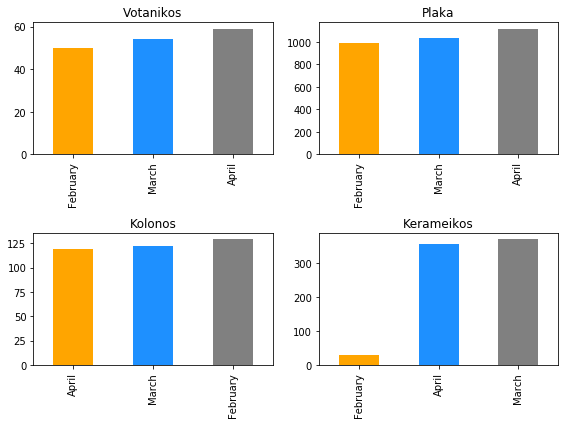

In [14]:
rand_neighbourhoods = random.choices(neighbourhoods, k=4)

fig = plt.figure()

for idx, rand_neighbourhood in enumerate(rand_neighbourhoods):
    ax = fig.add_subplot(2, 2, idx+1)
    df.loc[df['neighbourhood'] == rand_neighbourhood]['month'].value_counts().sort_values().plot(kind = 'bar', color = ['orange', 'dodgerblue', 'gray'], figsize = (8, 6))
    ax.set_title(rand_neighbourhood)

plt.tight_layout()
plt.show()

## Question 1.6

Plot the histogram of the neighborhood_group variable.


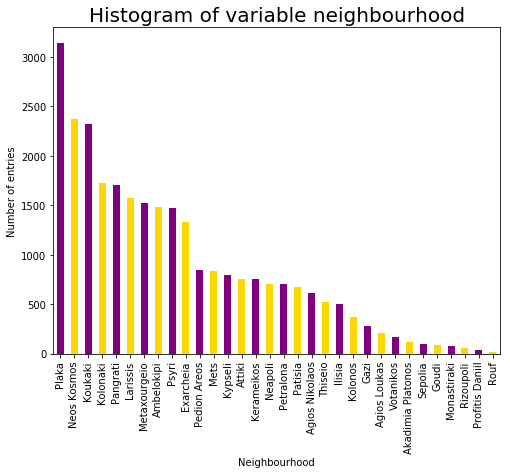

In [15]:
df['neighbourhood'].value_counts().plot(kind = 'bar', color = ['purple','gold'], figsize = (8, 6))
plt.title('Histogram of variable neighbourhood', fontsize = 20)
plt.xlabel('Neighbourhood')
plt.ylabel('Number of entries')
plt.show()

## Question 1.7

What is the most common type of room (room_type) in every neighbourhood?


In [16]:
print("Most common type of room in every neighbourhood: \n")
for neighbourhood in neighbourhoods:
    print("{}: {} - entries: {}".format(neighbourhood, 
                                    np.argmax(df.loc[df['neighbourhood'] == neighbourhood]['room_type'].value_counts()),
                                    np.max(df.loc[df['neighbourhood'] == neighbourhood]['room_type'].value_counts())))


Most common type of room in every neighbourhood: 

Plaka: Entire home/apt - entries: 2869
Neos Kosmos: Entire home/apt - entries: 2177
Koukaki: Entire home/apt - entries: 2104
Kolonaki: Entire home/apt - entries: 1615
Pangrati: Entire home/apt - entries: 1557
Larissis: Entire home/apt - entries: 1276
Metaxourgeio: Entire home/apt - entries: 1157
Ambelokipi: Entire home/apt - entries: 1386
Psyri: Entire home/apt - entries: 1182
Exarcheia: Entire home/apt - entries: 1171
Pedion Areos: Entire home/apt - entries: 679
Mets: Entire home/apt - entries: 782
Kypseli: Entire home/apt - entries: 645
Attiki: Entire home/apt - entries: 647
Kerameikos: Entire home/apt - entries: 682
Neapoli: Entire home/apt - entries: 608
Petralona: Entire home/apt - entries: 637
Patisia: Entire home/apt - entries: 620
Agios Nikolaos: Entire home/apt - entries: 524
Thiseio: Entire home/apt - entries: 478
Ilisia: Entire home/apt - entries: 473
Kolonos: Entire home/apt - entries: 321
Gazi: Entire home/apt - entries: 2

## Question 1.8

What is the most expensive room type?

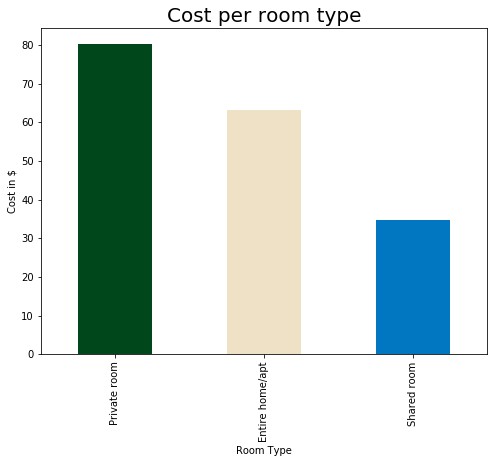

In [17]:
# Group the data by the room type
room_types = df.groupby('room_type')
# FInd out the mean value of the prices in each room type
prices = room_types['price'].mean().sort_values(ascending = False)
prices.plot(kind = 'bar', color=['#00471b', '#eee1c6', '#0077c0'] ,figsize = (8, 6))
plt.title('Cost per room type', fontsize = 20)
plt.xlabel('Room Type')
plt.ylabel('Cost in $')
plt.show()

In [18]:
types = prices.keys().tolist()
values = prices.tolist()

print('The most expensive room type is "{}" with {:.1f} mean price'.format(types[0], values[0]))

The most expensive room type is "Private room" with 80.3 mean price


## Question 1.9

Display in a map the listings of month Fenruary along with transit information in popup form.

In [19]:
# store in a new dataframe the info latitude/longitude/transit for month February
data = df[['latitude', 'longitude', 'transit']].loc[df['month'] == 'February']
data.dropna(inplace=True)
tooltip = 'Click me!'

for row in data.itertuples():
    mapit = folium.Map(location=[row.latitude, row.longitude], zoom_start=12)

for row in data[:100].itertuples():
    folium.Marker(location=[row.latitude, row.longitude], popup=row.transit, icon=folium.Icon(icon='info-sign')).add_to(mapit)

In [20]:
# Display map generated from Folium
mapit

## Question 10

Create wordclouds for columns neighbourhood/transit/description/last_review.

### Wordcloud for neighbourhood

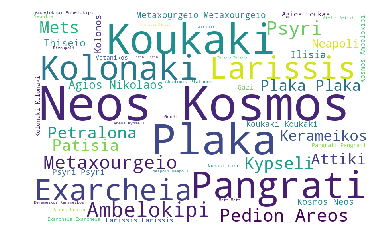

In [21]:
df['neighbourhood'].dropna(inplace=True)
wordcloud = WordCloud(max_words=1000,width=840, height=540, background_color="white").generate(' '.join(df['neighbourhood'].tolist()))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Wordcloud for transit

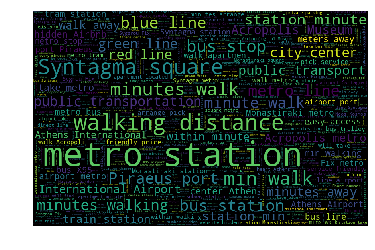

In [22]:
df['transit'].dropna(inplace=True)
wordcloud = WordCloud(max_words=1000,width=840, height=540, background_color="black").generate(' '.join(df['transit'].tolist()))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Wordcloud for description

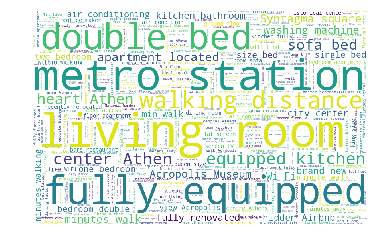

In [23]:
df['description'].dropna(inplace=True)
wordcloud = WordCloud(max_words=1000,width=840, height=540, background_color="white").generate(' '.join(df['description'].tolist()))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Wordcloud for last review

last_review column is an arethmetic one, thus, a wordcloud can not be created

## Extra Questions

### Question 1

Which are the neighbourhoods with the best review score?

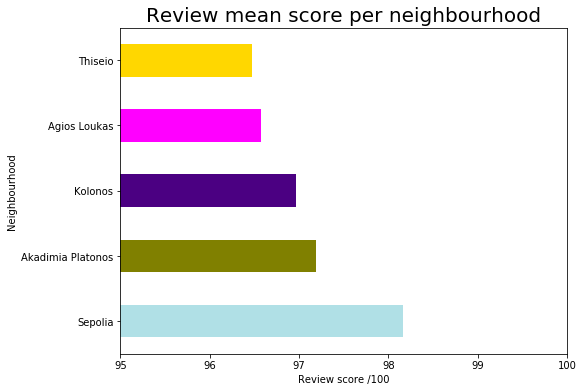

In [24]:
# Note: the neighs is the df grouped by the neighbourhood field, as stated above
scores = neighs['review_scores_rating'].mean().sort_values(ascending = False).head(5)
scores.plot(kind = 'barh', color=['powderblue', 'olive', 'indigo', 'magenta', 'gold'] ,figsize = (8, 6))
plt.title('Review mean score per neighbourhood', fontsize = 20)
# We know that the reviews are high, so no need to use all the range (0-100)
plt.xlim((95,100))
plt.ylabel('Neighbourhood')
plt.xlabel('Review score /100')
plt.show()

In [25]:
list_of_neighs = scores.keys().tolist()
n_scores = scores.tolist()
# And print its members
print("Top 5 neighbourhoods are: \n")
for i,n in enumerate(list_of_neighs):
    print('{} with {:.2f} review score'.format(n, n_scores[i]))

Top 5 neighbourhoods are: 

Sepolia with 98.17 review score
Akadimia Platonos with 97.19 review score
Kolonos with 96.96 review score
Agios Loukas with 96.58 review score
Thiseio with 96.48 review score


### Question 2

How many people in average each room type accommodates?

In [26]:
room_types = df['room_type'].value_counts().keys()
print("Average number of people each room type accommodates: \n")
for room_type in room_types:
    print("{}: {}".format(room_type, round(df.loc[df['room_type'] == room_type]['accommodates'].mean())))

Average number of people each room type accommodates: 

Entire home/apt: 4
Private room: 2
Shared room: 5


## Recommendation system

At first, create a new dataframe containing only the info id/name/description

In [27]:
df = df[['id', 'name', 'description']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28122 entries, 0 to 28121
Data columns (total 3 columns):
id             28122 non-null int64
name           28092 non-null object
description    27833 non-null object
dtypes: int64(1), object(2)
memory usage: 659.2+ KB


In [28]:
df.head()

,id,name,description
0,10595,"96m2, 3BR, 2BA, Metro, WI-FI etc...",Athens Furnished Apartment No6 is 3-bedroom ap...
1,10988,"75m2, 2-br, metro, wi-fi, cable TV",Athens Furnished Apartment No4 is 2-bedroom ap...
2,10990,"50m2, Metro, WI-FI, cableTV, more",Athens Furnished Apartment No3 is 1-bedroom ap...
3,10993,"Studio, metro, cable tv, wi-fi, etc",The Studio is an -excellent located -close t...
4,10995,"47m2, close to metro,cable TV,wi-fi",AQA No2 is 1-bedroom apartment (47m2) -excell...


In [29]:
# drop any NaN value
df.dropna(inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27803 entries, 0 to 28121
Data columns (total 3 columns):
id             27803 non-null int64
name           27803 non-null object
description    27803 non-null object
dtypes: int64(1), object(2)
memory usage: 868.8+ KB


### Preprocessing 

Now define our text precessing function. It will remove any punctuation and stopwords. Also it will convert all letters to lowercase and perform stemming aswell.

In [31]:
def preprocess_text(text):
    # remove all punctuation
    text = re.sub(r'[^\w\d\s]', ' ', text)
    # collapse all white spaces
    text = re.sub(r'\s+', ' ', text)
    # convert to lower case
    text = re.sub(r'^\s+|\s+?$', '', text.lower())
    # remove stop words and perform stemming
    stop_words = nltk.corpus.stopwords.words('english')
    lemmatizer = WordNetLemmatizer() 
    return ' '.join(
        lemmatizer.lemmatize(term) 
        for term in text.split()
        if term not in set(stop_words)
    )

In [32]:
# Concatenate name and description in one column and perform preprocessing
df['info'] = df['name'] + df['description']
df['processed_info'] = df['info'].apply(lambda row : preprocess_text(row))
df.head()

,id,name,description,info,processed_info
0,10595,"96m2, 3BR, 2BA, Metro, WI-FI etc...",Athens Furnished Apartment No6 is 3-bedroom ap...,"96m2, 3BR, 2BA, Metro, WI-FI etc...Athens Furn...",96m2 3br 2ba metro wi fi etc athens furnished ...
1,10988,"75m2, 2-br, metro, wi-fi, cable TV",Athens Furnished Apartment No4 is 2-bedroom ap...,"75m2, 2-br, metro, wi-fi, cable TVAthens Furni...",75m2 2 br metro wi fi cable tvathens furnished...
2,10990,"50m2, Metro, WI-FI, cableTV, more",Athens Furnished Apartment No3 is 1-bedroom ap...,"50m2, Metro, WI-FI, cableTV, moreAthens Furnis...",50m2 metro wi fi cabletv moreathens furnished ...
3,10993,"Studio, metro, cable tv, wi-fi, etc",The Studio is an -excellent located -close t...,"Studio, metro, cable tv, wi-fi, etcThe Studio ...",studio metro cable tv wi fi etcthe studio exce...
4,10995,"47m2, close to metro,cable TV,wi-fi",AQA No2 is 1-bedroom apartment (47m2) -excell...,"47m2, close to metro,cable TV,wi-fiAQA No2 is ...",47m2 close metro cable tv wi fiaqa no2 1 bedro...


In the queries below we do not want the duplicate listings over the different months. So, we proceed on deleting those who have the same id 

In [33]:
df.drop_duplicates(subset=['id'], keep='first', inplace=True)
df.reset_index()

,index,id,name,description,info,processed_info
0,0,10595,"96m2, 3BR, 2BA, Metro, WI-FI etc...",Athens Furnished Apartment No6 is 3-bedroom ap...,"96m2, 3BR, 2BA, Metro, WI-FI etc...Athens Furn...",96m2 3br 2ba metro wi fi etc athens furnished ...
1,1,10988,"75m2, 2-br, metro, wi-fi, cable TV",Athens Furnished Apartment No4 is 2-bedroom ap...,"75m2, 2-br, metro, wi-fi, cable TVAthens Furni...",75m2 2 br metro wi fi cable tvathens furnished...
2,2,10990,"50m2, Metro, WI-FI, cableTV, more",Athens Furnished Apartment No3 is 1-bedroom ap...,"50m2, Metro, WI-FI, cableTV, moreAthens Furnis...",50m2 metro wi fi cabletv moreathens furnished ...
3,3,10993,"Studio, metro, cable tv, wi-fi, etc",The Studio is an -excellent located -close t...,"Studio, metro, cable tv, wi-fi, etcThe Studio ...",studio metro cable tv wi fi etcthe studio exce...
4,4,10995,"47m2, close to metro,cable TV,wi-fi",AQA No2 is 1-bedroom apartment (47m2) -excell...,"47m2, close to metro,cable TV,wi-fiAQA No2 is ...",47m2 close metro cable tv wi fiaqa no2 1 bedro...
5,5,27262,"54m2, 1-br, cable tv, wi-fi, metro",Big 1-bedroom apartment that can accommodate 4...,"54m2, 1-br, cable tv, wi-fi, metroBig 1-bedroo...",54m2 1 br cable tv wi fi metrobig 1 bedroom ap...
6,6,28186,❤️Deluxe central loft near Acropolis❤️,⭐️Don't waste your precious time commuting. ⭐️...,❤️Deluxe central loft near Acropolis❤️⭐️Don't ...,deluxe central loft near acropolis waste preci...
7,7,31155,sleep on sailing boat,"on beautiful island of Aigina, 30 minutes from...",sleep on sailing boaton beautiful island of Ai...,sleep sailing boaton beautiful island aigina 3...
8,8,33704,"Artist's studio in Athens, safe area, near metro",Metro from Airport (4min to station) Safe area...,"Artist's studio in Athens, safe area, near met...",artist studio athens safe area near metrometro...
9,9,38100,Stay at the heart of Athens (100m²),Located in one of the most luxurious and safer...,Stay at the heart of Athens (100m²)Located in ...,stay heart athens 100m² located one luxurious ...


### Term Frequency - Inverse Document Frequency

In [ ]:
tfidf_data = TfidfVectorizer(ngram_range=(1, 2)).fit_transform(df.processed_info)
print(tfidf_data.shape)

As we expected our vectorized data using TF-IDF method contains 10257 rows as the number of listings and 294419 features

### Listings similarity 

In this step, we are going to calculate the similarity of each listing with the remaining ones using tfidf_vec and cosine similarity function

In [ ]:
cosine_similarities = cosine_similarity(tfidf_data)
final_similarities = cosine_similarities.copy()

Our numpy array final_similarities is symmetrical by its diagonal. So, we have to fill with zeroes the upper triangle along with its diagonal.

In [ ]:
np.fill_diagonal(final_similarities, 0.0)
final_similarities *= np.tri(*final_similarities.shape)

Compute top 100 most similar 

In [ ]:
N = 100
idx = np.argsort(final_similarities.ravel())[-N:][::-1] 
topN_val = final_similarities.ravel()[idx]
topN_val_indices = np.c_[np.unravel_index(idx, final_similarities.shape)]

Store them to dictionary

In [ ]:
top100_most_similar = {}
for i in range(0, topN_val_indices.shape[0]):
    x, y = topN_val_indices[i]
    top100_most_similar[(x, y)] = topN_val[i]

Print 100 most similar listings

In [ ]:
print("The 100 most similar listing are: \n")
for k, v in top100_most_similar.items():
    index1, index2 = k
    print("Id: {} - Id: {} - Similarity: {:.2f}".format(df.iloc[index1]['id'], df.iloc[index2]['id'], v))

### Recommend most similar listings

In [ ]:
def recommend(item_id = 10988, num = 5):
    id_list = df.index[df['id'] == item_id].tolist()
    if (len(id_list) > 0):
        listing_id = id_list[0]
    else:
        print('No such listing found')
        return
    
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(tfidf_data)

    distances, indices = model_knn.kneighbors(tfidf_data[listing_id].reshape(1,-1), n_neighbors = num)    
    print('Recommending {} listings similar to {}:'.format(num, listing_id))
    
    for i in range(0, len(distances.flatten())):
        print('---------------------------------------------------------')
        print("Recommended: {}\n".format(df.iloc[df.index[indices.flatten()[i]]]['name']))
        print('Description: "{}"\n'.format(df.iloc[df.index[indices.flatten()[i]]]['description']))
        print('(score: {})'.format(distances.flatten()[i]))   

In [ ]:
recommend()

### Top-10 words which commonly co-occur

In [ ]:
"""
A utility function which constructs
a list of all words in the column
processed_info.
"""
def get_corpus(data):
    corpus = []
    for row in data.iteritems():
        for sub_item in row[1].split(' '):
            corpus.append(sub_item)
    return corpus

In [ ]:
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(get_corpus(df['processed_info']))
top10_collocations = finder.nbest(BigramAssocMeasures.pmi, 10)

In [ ]:
print("Top-10 words which commonly co-occur: \n")
for pair_words in top10_collocations:
    print("{} - {}".format(pair_words[0], pair_words[1]))